# Model Evaluation: Genius Song Lyrics Subset (1%)

**Dataset:** 34'049 Songs | 26'408 Artists | 6 Genres

**Embeddings:** Word2Vec · TF-IDF · SentenceTransformer (MiniLM)

**Classifiers:** LinearSVC · Logistic Regression · Random Forest

**Purpose:** Evaluate multiple machine learning models for automatic song genre classification based on different text embedding methods. This notebook compares traditional and modern embedding strategies and assesses how well each classifier performs across genre categories.

**Details:**

- Generates document-level embeddings using
    - Word2Vec (self-trained)
    - TF-IDF (character-level n-grams)
    - SentenceTransformer MiniLM (Transformer-based)

- Trains and evaluates several classifiers:
    - LinearSVC
    - Logistic Regression
    - Random Forest

- Computes:
    - Accuracy & Balanced Accuracy
    - Classification Reports
    - Normalized Confusion Matrices

- Summarizes all results in comparative tables and interprets model behavior.

---

# 1. Imports and Setup
## 1.1 Import Libraries

In [202]:
import numpy as np
import pandas as pd
import ast
import os
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier


from sentence_transformers import SentenceTransformer

import matplotlib.pyplot as plt
import seaborn as sns
import torch

import re

from gensim.models import Word2Vec

print(np.__version__)
print(torch.__version__)

2.3.3
2.2.2


## 1.2 Load Data

In [162]:
df = pd.read_csv("data/clean/data.csv")

df["tokens"] = df["tokens"].apply(ast.literal_eval)
texts = df["tokens"]
labels = df["tag"]

print(df['tokens'].head())
print(type(df["tokens"].iloc[0]))

0    [bitch, clean, two, sticks, like, chow, mein, ...
1    [old, girl, left, old, bull, shit, play, off, ...
2    [avast, there, matey, haha, pirate, asks, pass...
3    [just, throw, glimpse, shell, ghostly, voices,...
4    [miss, taste, sweeter, life, miss, conversatio...
Name: tokens, dtype: object
<class 'list'>


## 1.3 Encode labels

In [163]:
# Encode string labels (genres) into integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels)

print("Classes (genres):")
for idx, cls in enumerate(label_encoder.classes_):
    print(f"{idx}: {cls}")

Classes (genres):
0: country
1: misc
2: pop
3: rap
4: rb
5: rock


# 2. Model
## 2.1 Train-Test-Split

In [164]:
X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    texts,
    y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded,
)

print("Train size:", X_train_texts.shape[0])
print("Test size:", X_test_texts.shape[0])

Train size: 27239
Test size: 6810


## 2.2 Embedding (Word2Vec)

In [165]:
X_train_tokens = X_train_texts.tolist() # list of lists
X_test_tokens  = X_test_texts.tolist()

In [166]:
w2v = Word2Vec(
    sentences=X_train_tokens,
    vector_size=100,
    window=5,
    min_count=5,
    workers=4,
    sg=1,
    epochs=10,
    seed=42
)

print("Vocabulary size:", len(w2v.wv))

Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_fl

Vocabulary size: 32407


In [167]:
def embed_sentence(tokens, model):
    vectors = [model.wv[w] for w in tokens if w in model.wv]
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

X_train_w2v = np.vstack([embed_sentence(toks, w2v) for toks in X_train_tokens])
X_test_w2v  = np.vstack([embed_sentence(toks, w2v) for toks in X_test_tokens])

print("X_train_w2v shape:", X_train_w2v.shape)
print("X_test_w2v shape:", X_test_w2v.shape)

X_train_w2v shape: (27239, 100)
X_test_w2v shape: (6810, 100)


### 2.2.1 Train Classification-Model (LinearSVC)

In [168]:
clf_w2v_svc = LinearSVC(class_weight="balanced", max_iter=10000)
clf_w2v_svc.fit(X_train_w2v, y_train)

,"penalty penalty: {'l1', 'l2'}, default='l2'Specifies the norm used in the penalization. The 'l2'penalty is the standard used in SVC. The 'l1' leads to ``coef_``vectors that are sparse.",'l2'
,"loss loss: {'hinge', 'squared_hinge'}, default='squared_hinge'Specifies the loss function. 'hinge' is the standard SVM loss(used e.g. by the SVC class) while 'squared_hinge' is thesquare of the hinge loss. The combination of ``penalty='l1'``and ``loss='hinge'`` is not supported.",'squared_hinge'
,"dual dual: ""auto"" or bool, default=""auto""Select the algorithm to either solve the dual or primaloptimization problem. Prefer dual=False when n_samples > n_features.`dual=""auto""` will choose the value of the parameter automatically,based on the values of `n_samples`, `n_features`, `loss`, `multi_class`and `penalty`. If `n_samples` < `n_features` and optimizer supportschosen `loss`, `multi_class` and `penalty`, then dual will be set to True,otherwise it will be set to False... versionchanged:: 1.3 The `""auto""` option is added in version 1.3 and will be the default in version 1.5.",'auto'
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive.For an intuitive visualization of the effects of scalingthe regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1.0
,"multi_class multi_class: {'ovr', 'crammer_singer'}, default='ovr'Determines the multi-class strategy if `y` contains more thantwo classes.``""ovr""`` trains n_classes one-vs-rest classifiers, while``""crammer_singer""`` optimizes a joint objective over all classes.While `crammer_singer` is interesting from a theoretical perspectiveas it is consistent, it is seldom used in practice as it rarely leadsto better accuracy and is more expensive to compute.If ``""crammer_singer""`` is chosen, the options loss, penalty and dualwill be ignored.",'ovr'
,"fit_intercept fit_intercept: bool, default=TrueWhether or not to fit an intercept. If set to True, the feature vectoris extended to include an intercept term: `[x_1, ..., x_n, 1]`, where1 corresponds to the intercept. If set to False, no intercept will beused in calculations (i.e. data is expected to be already centered).",True
,"intercept_scaling intercept_scaling: float, default=1.0When `fit_intercept` is True, the instance vector x becomes ``[x_1,..., x_n, intercept_scaling]``, i.e. a ""synthetic"" feature with aconstant value equal to `intercept_scaling` is appended to the instancevector. The intercept becomes intercept_scaling * synthetic featureweight. Note that liblinear internally penalizes the intercept,treating it like any other term in the feature vector. To reduce theimpact of the regularization on the intercept, the `intercept_scaling`parameter can be set to a value greater than 1; the higher the value of`intercept_scaling`, the lower the impact of regularization on it.Then, the weights become `[w_x_1, ..., w_x_n,w_intercept*intercept_scaling]`, where `w_x_1, ..., w_x_n` representthe feature weights and the intercept weight is scaled by`intercept_scaling`. This scaling allows the intercept term to have adifferent regularization behavior compared to the other features.",1
,"class_weight class_weight: dict or 'balanced', default=NoneSet the parameter C of class i to ``class_weight[i]*C`` forSVC. If not given, all classes are supposed to haveweight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.",'balanced'
,"verbose verbose: int, default=0Enable verbose output. Note that this setting takes advantage of aper-process runtime setting in liblinear that, if enabled, may not workproperly in a multithreaded context.",0
,"random_state random_state: int, RandomState instance or None, default=NoneControls the pseud

In [169]:
y_pred_w2v_svc = clf_w2v_svc.predict(X_test_w2v)

print("=== Word2Vec + LinearSVC ===")
print("Accuracy:", accuracy_score(y_test, y_pred_w2v_svc))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred_w2v_svc))
print(classification_report(y_test, y_pred_w2v_svc, target_names=label_encoder.classes_))

=== Word2Vec + LinearSVC ===
Accuracy: 0.5726872246696035
Balanced accuracy: 0.5011590090396437
              precision    recall  f1-score   support

     country       0.16      0.40      0.22       174
        misc       0.37      0.66      0.47       290
         pop       0.62      0.53      0.57      2820
         rap       0.77      0.85      0.81      1945
          rb       0.20      0.24      0.22       306
        rock       0.46      0.33      0.39      1275

    accuracy                           0.57      6810
   macro avg       0.43      0.50      0.45      6810
weighted avg       0.59      0.57      0.57      6810



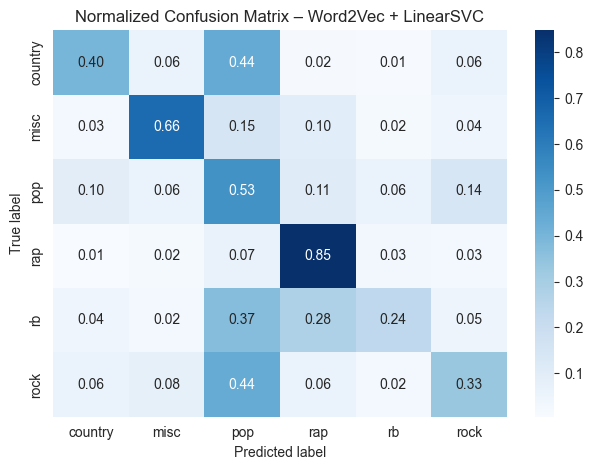

In [170]:
cm = confusion_matrix(y_test, y_pred_w2v_svc, labels=label_encoder.transform(label_encoder.classes_))

cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)

plt.figure()
sns.heatmap(
    cm_norm,
    annot=True,
    fmt='.2f',
    cmap="Blues",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Normalized Confusion Matrix – Word2Vec + LinearSVC")
plt.tight_layout()
plt.show()


### 2.2.2 Train Classification-Model (Logistic Regression)

In [171]:
clf_w2v_logreg = LogisticRegression(
    max_iter=2000,
    n_jobs=-1,
    class_weight="balanced"
)

clf_w2v_logreg.fit(X_train_w2v, y_train)

/Users/selinasteiner/Desktop/TA/TA-Project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :ter

In [172]:
y_pred_w2v_logreg = clf_w2v_logreg.predict(X_test_w2v)


print("=== Word2Vec + Logistic Regression ===")
print("Accuracy:", accuracy_score(y_test, y_pred_w2v_logreg))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred_w2v_logreg))
print("\nClassification report:\n")
print(classification_report(y_test, y_pred_w2v_logreg, target_names=label_encoder.classes_))

=== Word2Vec + Logistic Regression ===
Accuracy: 0.4638766519823789
Balanced accuracy: 0.5525984575276645

Classification report:

              precision    recall  f1-score   support

     country       0.11      0.62      0.19       174
        misc       0.32      0.69      0.44       290
         pop       0.65      0.20      0.31      2820
         rap       0.82      0.76      0.79      1945
          rb       0.16      0.54      0.25       306
        rock       0.42      0.50      0.46      1275

    accuracy                           0.46      6810
   macro avg       0.41      0.55      0.41      6810
weighted avg       0.61      0.46      0.47      6810



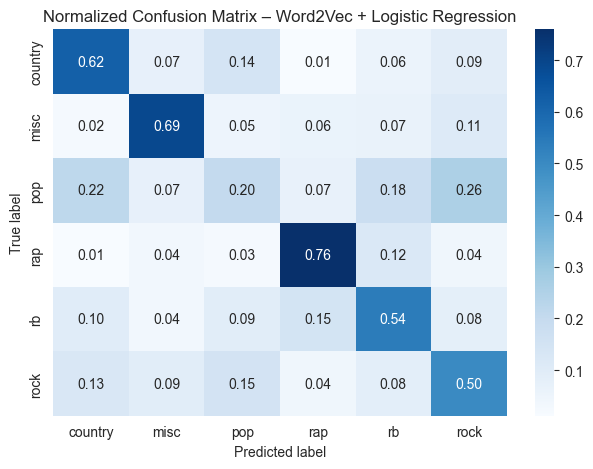

In [173]:
cm = confusion_matrix(y_test, y_pred_w2v_logreg, labels=label_encoder.transform(label_encoder.classes_))

cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)

plt.figure()
sns.heatmap(
    cm_norm,
    annot=True,
    fmt='.2f',
    cmap="Blues",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Normalized Confusion Matrix – Word2Vec + Logistic Regression")
plt.tight_layout()
plt.show()

### 2.2.3 Train Classification-Model (Random Forest)

In [174]:
clf_w2v_rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=20,
    min_samples_leaf=3,
    max_features="sqrt",
    class_weight="balanced",
    n_jobs=-1,
    random_state=42,
)

clf_w2v_rf.fit(X_train_w2v, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",400
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",20
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",3
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y

In [175]:
y_pred_w2v_rf = clf_w2v_rf.predict(X_test_w2v)

print("=== Word2Vec + Random Forest ===")
print("Accuracy:", accuracy_score(y_test, y_pred_w2v_rf))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred_w2v_rf))
print("\nClassification report:\n")
print(classification_report(
    y_test,
    y_pred_w2v_rf,
    labels=np.arange(len(label_encoder.classes_)),
    target_names=label_encoder.classes_
))

=== Word2Vec + Random Forest ===
Accuracy: 0.637151248164464
Balanced accuracy: 0.39661711379605746

Classification report:

              precision    recall  f1-score   support

     country       0.33      0.01      0.02       174
        misc       0.67      0.49      0.57       290
         pop       0.58      0.82      0.68      2820
         rap       0.80      0.82      0.81      1945
          rb       0.20      0.02      0.03       306
        rock       0.51      0.21      0.30      1275

    accuracy                           0.64      6810
   macro avg       0.51      0.40      0.40      6810
weighted avg       0.61      0.64      0.59      6810



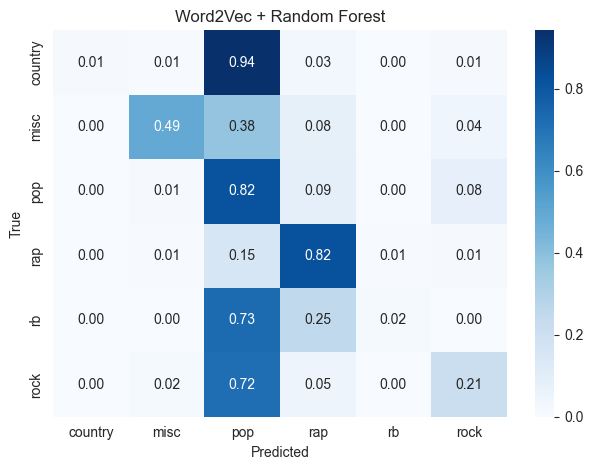

In [176]:
cm = confusion_matrix(y_test, y_pred_w2v_rf, labels=np.arange(len(label_encoder.classes_))
                      )
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

plt.figure()
sns.heatmap(
    cm_norm,
    annot=True,
    cmap="Blues",
    fmt=".2f",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
)
plt.title("Word2Vec + Random Forest")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

### 2.2.4 Word2Vec – Summary of Classifier Performance

The three classifiers applied on Word2Vec embeddings show distinct strengths and weaknesses:

#### LinearSVC
    - Accuracy: ~0.577
    - Balanced Accuracy: ~0.508
LinearSVC delivers the most consistent overall performance. It performs well on dominant genres (rap, pop) and provides the best balance between overall accuracy and fairness across classes, although minority genres remain challenging.

#### Logistic Regression
    - Accuracy: ~0.463
    - Balanced Accuracy: ~0.551
Logistic Regression achieves the highest balanced accuracy, meaning it distributes attention more evenly across genres. However, its overall accuracy is lower because it struggles with large classes such as pop.

#### Random Forest
    - Accuracy: ~0.648
    - Balanced Accuracy: ~0.405
The tuned Random Forest achieves the highest accuracy among the Word2Vec models, primarily due to very strong performance on the majority classes (pop, rap). However, its predictions for minority genres such as country, rb and rock remain weak, leading to a substantially lower balanced accuracy. This indicates a persistent bias toward large classes.

#### Conclusion

**Best overall performer:** LinearSVC (strong accuracy with the most balanced class behavior)

**Best for minority classes:** Logistic Regression (highest balanced accuracy)

**Best raw accuracy but least fair:** Random Forest (excellent majority-class performance, limited generalization to minority genres)

## 2.3 Embedding (TF-IDF)

In [177]:
X_train_texts_char = X_train_texts.apply(lambda toks: " ".join(toks))
X_test_texts_char  = X_test_texts.apply(lambda toks: " ".join(toks))

In [178]:
tfidf = TfidfVectorizer(
    analyzer="char",
    ngram_range=(3, 5),
    min_df=5,
    max_df=0.9,
)

X_train_tfidf = tfidf.fit_transform(X_train_texts_char)
X_test_tfidf  = tfidf.transform(X_test_texts_char)

### 2.3.1 Train Classification-Model (LinearSVC)

In [179]:
clf_tfidf_svc = LinearSVC(class_weight='balanced')
clf_tfidf_svc.fit(X_train_tfidf, y_train)

,"penalty penalty: {'l1', 'l2'}, default='l2'Specifies the norm used in the penalization. The 'l2'penalty is the standard used in SVC. The 'l1' leads to ``coef_``vectors that are sparse.",'l2'
,"loss loss: {'hinge', 'squared_hinge'}, default='squared_hinge'Specifies the loss function. 'hinge' is the standard SVM loss(used e.g. by the SVC class) while 'squared_hinge' is thesquare of the hinge loss. The combination of ``penalty='l1'``and ``loss='hinge'`` is not supported.",'squared_hinge'
,"dual dual: ""auto"" or bool, default=""auto""Select the algorithm to either solve the dual or primaloptimization problem. Prefer dual=False when n_samples > n_features.`dual=""auto""` will choose the value of the parameter automatically,based on the values of `n_samples`, `n_features`, `loss`, `multi_class`and `penalty`. If `n_samples` < `n_features` and optimizer supportschosen `loss`, `multi_class` and `penalty`, then dual will be set to True,otherwise it will be set to False... versionchanged:: 1.3 The `""auto""` option is added in version 1.3 and will be the default in version 1.5.",'auto'
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive.For an intuitive visualization of the effects of scalingthe regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1.0
,"multi_class multi_class: {'ovr', 'crammer_singer'}, default='ovr'Determines the multi-class strategy if `y` contains more thantwo classes.``""ovr""`` trains n_classes one-vs-rest classifiers, while``""crammer_singer""`` optimizes a joint objective over all classes.While `crammer_singer` is interesting from a theoretical perspectiveas it is consistent, it is seldom used in practice as it rarely leadsto better accuracy and is more expensive to compute.If ``""crammer_singer""`` is chosen, the options loss, penalty and dualwill be ignored.",'ovr'
,"fit_intercept fit_intercept: bool, default=TrueWhether or not to fit an intercept. If set to True, the feature vectoris extended to include an intercept term: `[x_1, ..., x_n, 1]`, where1 corresponds to the intercept. If set to False, no intercept will beused in calculations (i.e. data is expected to be already centered).",True
,"intercept_scaling intercept_scaling: float, default=1.0When `fit_intercept` is True, the instance vector x becomes ``[x_1,..., x_n, intercept_scaling]``, i.e. a ""synthetic"" feature with aconstant value equal to `intercept_scaling` is appended to the instancevector. The intercept becomes intercept_scaling * synthetic featureweight. Note that liblinear internally penalizes the intercept,treating it like any other term in the feature vector. To reduce theimpact of the regularization on the intercept, the `intercept_scaling`parameter can be set to a value greater than 1; the higher the value of`intercept_scaling`, the lower the impact of regularization on it.Then, the weights become `[w_x_1, ..., w_x_n,w_intercept*intercept_scaling]`, where `w_x_1, ..., w_x_n` representthe feature weights and the intercept weight is scaled by`intercept_scaling`. This scaling allows the intercept term to have adifferent regularization behavior compared to the other features.",1
,"class_weight class_weight: dict or 'balanced', default=NoneSet the parameter C of class i to ``class_weight[i]*C`` forSVC. If not given, all classes are supposed to haveweight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.",'balanced'
,"verbose verbose: int, default=0Enable verbose output. Note that this setting takes advantage of aper-process runtime setting in liblinear that, if enabled, may not workproperly in a multithreaded context.",0
,"random_state random_state: int, RandomState instance or None, default=NoneControls the pseud

In [180]:
y_pred_tfidf_svc = clf_tfidf_svc.predict(X_test_tfidf)

print("=== TF-IDF + LinearSVC ===")
print("Accuracy:", accuracy_score(y_test, y_pred_tfidf_svc))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred_tfidf_svc))
print("\nClassification report:\n")
print(classification_report(y_test, y_pred_tfidf_svc, target_names=label_encoder.classes_))

=== TF-IDF + LinearSVC ===
Accuracy: 0.593245227606461
Balanced accuracy: 0.4577621690222169

Classification report:

              precision    recall  f1-score   support

     country       0.26      0.23      0.24       174
        misc       0.60      0.51      0.55       290
         pop       0.60      0.61      0.60      2820
         rap       0.82      0.82      0.82      1945
          rb       0.21      0.20      0.20       306
        rock       0.37      0.37      0.37      1275

    accuracy                           0.59      6810
   macro avg       0.48      0.46      0.47      6810
weighted avg       0.59      0.59      0.59      6810



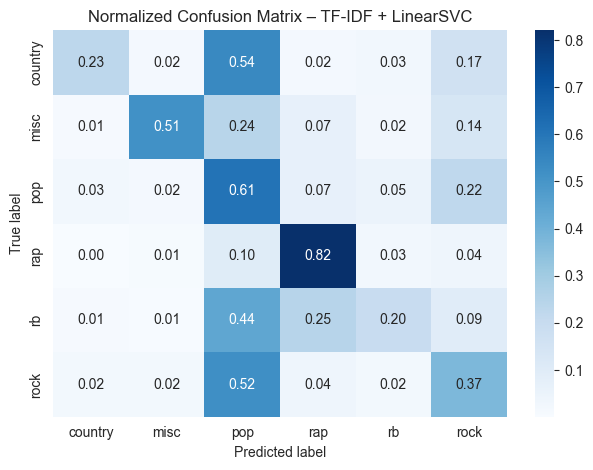

In [181]:
cm = confusion_matrix(y_test, y_pred_tfidf_svc, labels=label_encoder.transform(label_encoder.classes_))
cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)

plt.figure()
sns.heatmap(
    cm_norm,
    annot=True,
    fmt='.2f',
    cmap="Blues",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Normalized Confusion Matrix – TF-IDF + LinearSVC")
plt.tight_layout()
plt.show()

### 2.3.2 Train Classification-Model (Logistic Regression)

In [182]:
clf_tfidf_logreg = LogisticRegression(
    max_iter=2000,
    n_jobs=-1,
    class_weight="balanced"
)

clf_tfidf_logreg.fit(X_train_tfidf, y_train)

/Users/selinasteiner/Desktop/TA/TA-Project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :ter

In [183]:
y_pred_tfidf_logreg = clf_tfidf_logreg.predict(X_test_tfidf)

print("=== TF-IDF + Logistic Regression ===")
print("Accuracy:", accuracy_score(y_test, y_pred_tfidf_logreg))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred_tfidf_logreg))
print("\nClassification report:\n")
print(classification_report(y_test, y_pred_tfidf_logreg, target_names=label_encoder.classes_))

=== TF-IDF + Logistic Regression ===
Accuracy: 0.5505139500734214
Balanced accuracy: 0.5346010324006597

Classification report:

              precision    recall  f1-score   support

     country       0.18      0.44      0.26       174
        misc       0.46      0.62      0.53       290
         pop       0.63      0.42      0.50      2820
         rap       0.85      0.78      0.82      1945
          rb       0.19      0.42      0.26       306
        rock       0.40      0.51      0.45      1275

    accuracy                           0.55      6810
   macro avg       0.45      0.53      0.47      6810
weighted avg       0.61      0.55      0.57      6810



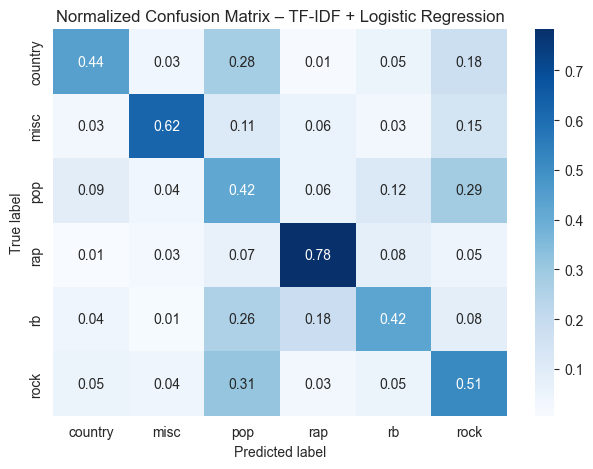

In [184]:
cm = confusion_matrix(y_test, y_pred_tfidf_logreg, labels=label_encoder.transform(label_encoder.classes_))
cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)

plt.figure()
sns.heatmap(
    cm_norm,
    annot=True,
    fmt='.2f',
    cmap="Blues",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Normalized Confusion Matrix – TF-IDF + Logistic Regression")
plt.tight_layout()
plt.show()

### 2.3.3 Train Classification-Model (Random Forest)

In [185]:
clf_tfidf_rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=20,
    min_samples_leaf=3,
    max_features="sqrt",
    class_weight="balanced",
    n_jobs=-1,
    random_state=42,
)

clf_tfidf_rf.fit(X_train_tfidf, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",400
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",20
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",3
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y

In [186]:
y_pred_tfidf_rf = clf_tfidf_rf.predict(X_test_tfidf)

print("=== TF-IDF + Random Forest ===")
print("Accuracy:", accuracy_score(y_test, y_pred_tfidf_rf))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred_tfidf_rf))
print("\nClassification report:\n")
print(classification_report(
    y_test,
    y_pred_tfidf_rf,
    labels=np.arange(len(label_encoder.classes_)),
    target_names=label_encoder.classes_
))

=== TF-IDF + Random Forest ===
Accuracy: 0.581057268722467
Balanced accuracy: 0.40482606080274985

Classification report:

              precision    recall  f1-score   support

     country       0.33      0.01      0.01       174
        misc       0.89      0.35      0.50       290
         pop       0.62      0.50      0.55      2820
         rap       0.77      0.86      0.81      1945
          rb       0.19      0.14      0.16       306
        rock       0.36      0.57      0.44      1275

    accuracy                           0.58      6810
   macro avg       0.53      0.40      0.41      6810
weighted avg       0.60      0.58      0.57      6810



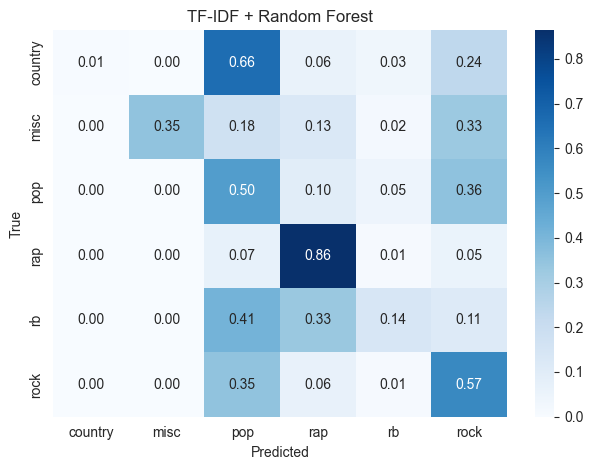

In [187]:
cm = confusion_matrix(
    y_test,
    y_pred_tfidf_rf,
    labels=np.arange(len(label_encoder.classes_))
)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

plt.figure()
sns.heatmap(
    cm_norm,
    annot=True,
    cmap="Blues",
    fmt=".2f",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
)
plt.title("TF-IDF + Random Forest")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

### 2.3.4 TF-IDF – Summary of Classifier Performance

The three classifiers applied on TF-IDF embeddings show different but consistent behavior, reflecting how well each model handles the character-level n-gram representation.

#### LinearSVC
    - Accuracy: ~0.593
    - Balanced Accuracy: ~0.458
LinearSVC provides the strongest overall performance for TF-IDF. It predicts dominant genres (rap, pop) reliably and achieves a stable overall accuracy. Performance on minority genres remains limited, resulting in only moderate balanced accuracy.

#### Logistic Regression
    - Accuracy: ~0.551
    - Balanced Accuracy: ~0.535
Logistic Regression delivers more balanced predictions across classes. It improves recall for smaller genres such as misc and rb, leading to the highest balanced accuracy among the TF-IDF classifiers. This comes at the cost of slightly lower accuracy on major genres.

#### Random Forest
    - Accuracy: ~0.581
    - Balanced Accuracy: ~0.405
The Random Forest achieves competitive accuracy but suffers from substantial class imbalance. It performs well on pop and rap, but predictions for minority genres are weak—especially country and rb—which significantly reduces the balanced accuracy.

#### Conclusion

**Best overall performer:** LinearSVC (best combination of accuracy and stability)

**Best class balance:** Logistic Regression (highest balanced accuracy; better minority recall)

**Highest accuracy but least fair:** Random Forest (acceptable accuracy, but strong majority-class focus)

## 2.4 Embedding (Transformer)

SentenceTransformer models (e.g., all-MiniLM-L6-v2) are based on Transformer architectures and include a fully integrated, pre-trained tokenization pipeline. This means that—unlike Word2Vec or TF-IDF—no manual preprocessing into tokens is required. Instead, each song is simply passed as a text string, and the model handles tokenization, embedding creation, and contextual encoding internally.

To ensure stable execution in environments without a GPU, the model can be explicitly moved to the CPU using `device="cpu"`. Using the CPU avoids GPU-related issues such as memory limits or hardware incompatibilities. While encoding becomes slower, it remains robust and fully deterministic.

In [188]:
model = SentenceTransformer("all-MiniLM-L6-v2", device="cpu")

In [189]:
X_train_sent = [" ".join(toks) for toks in X_train_texts]
X_test_sent  = [" ".join(toks) for toks in X_test_texts]

In [190]:
X_train_emb_st = model.encode(
    X_train_sent,
    batch_size=16,
    show_progress_bar=True,
    convert_to_numpy=False,
    convert_to_tensor=True,
)

X_test_emb_st = model.encode(
    X_test_sent,
    batch_size=16,
    show_progress_bar=True,
    convert_to_numpy=False,
    convert_to_tensor=True,
)

print("Shapes:", X_train_emb_st.shape, X_test_emb_st.shape)

Batches: 100%|██████████| 426/426 [03:53<00:00,  1.82it/s]

Shapes: torch.Size([27239, 384]) torch.Size([6810, 384])


In [191]:
X_train_emb_st = X_train_emb_st.tolist()
X_test_emb_st  = X_test_emb_st.tolist()

### 2.4.1 Train Classification-Model (LinearSVC)

In [192]:
clf_st_svc = LinearSVC(class_weight="balanced", max_iter=10000)
clf_st_svc.fit(X_train_emb_st, y_train)

,"penalty penalty: {'l1', 'l2'}, default='l2'Specifies the norm used in the penalization. The 'l2'penalty is the standard used in SVC. The 'l1' leads to ``coef_``vectors that are sparse.",'l2'
,"loss loss: {'hinge', 'squared_hinge'}, default='squared_hinge'Specifies the loss function. 'hinge' is the standard SVM loss(used e.g. by the SVC class) while 'squared_hinge' is thesquare of the hinge loss. The combination of ``penalty='l1'``and ``loss='hinge'`` is not supported.",'squared_hinge'
,"dual dual: ""auto"" or bool, default=""auto""Select the algorithm to either solve the dual or primaloptimization problem. Prefer dual=False when n_samples > n_features.`dual=""auto""` will choose the value of the parameter automatically,based on the values of `n_samples`, `n_features`, `loss`, `multi_class`and `penalty`. If `n_samples` < `n_features` and optimizer supportschosen `loss`, `multi_class` and `penalty`, then dual will be set to True,otherwise it will be set to False... versionchanged:: 1.3 The `""auto""` option is added in version 1.3 and will be the default in version 1.5.",'auto'
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive.For an intuitive visualization of the effects of scalingthe regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1.0
,"multi_class multi_class: {'ovr', 'crammer_singer'}, default='ovr'Determines the multi-class strategy if `y` contains more thantwo classes.``""ovr""`` trains n_classes one-vs-rest classifiers, while``""crammer_singer""`` optimizes a joint objective over all classes.While `crammer_singer` is interesting from a theoretical perspectiveas it is consistent, it is seldom used in practice as it rarely leadsto better accuracy and is more expensive to compute.If ``""crammer_singer""`` is chosen, the options loss, penalty and dualwill be ignored.",'ovr'
,"fit_intercept fit_intercept: bool, default=TrueWhether or not to fit an intercept. If set to True, the feature vectoris extended to include an intercept term: `[x_1, ..., x_n, 1]`, where1 corresponds to the intercept. If set to False, no intercept will beused in calculations (i.e. data is expected to be already centered).",True
,"intercept_scaling intercept_scaling: float, default=1.0When `fit_intercept` is True, the instance vector x becomes ``[x_1,..., x_n, intercept_scaling]``, i.e. a ""synthetic"" feature with aconstant value equal to `intercept_scaling` is appended to the instancevector. The intercept becomes intercept_scaling * synthetic featureweight. Note that liblinear internally penalizes the intercept,treating it like any other term in the feature vector. To reduce theimpact of the regularization on the intercept, the `intercept_scaling`parameter can be set to a value greater than 1; the higher the value of`intercept_scaling`, the lower the impact of regularization on it.Then, the weights become `[w_x_1, ..., w_x_n,w_intercept*intercept_scaling]`, where `w_x_1, ..., w_x_n` representthe feature weights and the intercept weight is scaled by`intercept_scaling`. This scaling allows the intercept term to have adifferent regularization behavior compared to the other features.",1
,"class_weight class_weight: dict or 'balanced', default=NoneSet the parameter C of class i to ``class_weight[i]*C`` forSVC. If not given, all classes are supposed to haveweight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.",'balanced'
,"verbose verbose: int, default=0Enable verbose output. Note that this setting takes advantage of aper-process runtime setting in liblinear that, if enabled, may not workproperly in a multithreaded context.",0
,"random_state random_state: int, RandomState instance or None, default=NoneControls the pseud

In [193]:
y_pred_st_svc = clf_st_svc.predict(X_test_emb_st)

print("=== SentenceTransformer (MiniLM) + LinearSVC ===")
print("Accuracy:", accuracy_score(y_test, y_pred_st_svc))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred_st_svc))
print("\nClassification report:\n")
print(classification_report(y_test,y_pred_st_svc,
                            labels=np.arange(len(label_encoder.classes_)),
                            target_names=label_encoder.classes_))

=== SentenceTransformer (MiniLM) + LinearSVC ===
Accuracy: 0.5718061674008811
Balanced accuracy: 0.5152474657069953

Classification report:

              precision    recall  f1-score   support

     country       0.14      0.42      0.21       174
        misc       0.37      0.66      0.47       290
         pop       0.64      0.50      0.56      2820
         rap       0.79      0.85      0.82      1945
          rb       0.20      0.29      0.23       306
        rock       0.46      0.38      0.42      1275

    accuracy                           0.57      6810
   macro avg       0.43      0.52      0.45      6810
weighted avg       0.61      0.57      0.58      6810



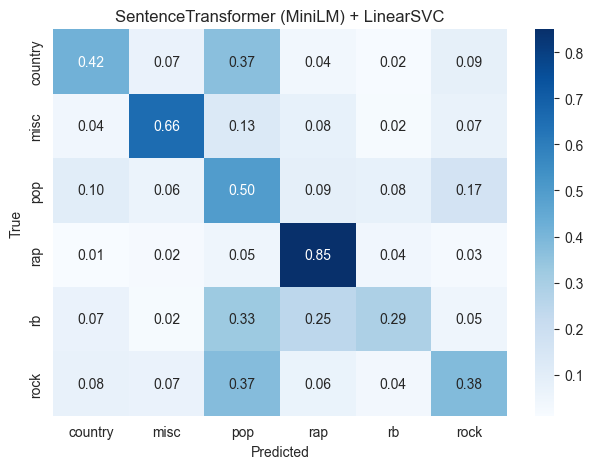

In [194]:
cm = confusion_matrix(y_test, y_pred_st_svc, labels=np.arange(len(label_encoder.classes_)))

cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

plt.figure()
sns.heatmap(
    cm_norm,
    annot=True,
    cmap="Blues",
    fmt=".2f",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
)
plt.title("SentenceTransformer (MiniLM) + LinearSVC")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

### 2.4.2 Train Classification-Model (Logistic Regression)

In [195]:
clf_tfidf_logreg = LogisticRegression(
    max_iter=2000,
    n_jobs=-1,
    class_weight="balanced"
)

clf_st_logreg.fit(X_train_emb_st, y_train)

/Users/selinasteiner/Desktop/TA/TA-Project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :ter

In [196]:
y_pred_st_logreg = clf_st_logreg.predict(X_test_emb_st)

print("=== SentenceTransformer (MiniLM) + Logistic Regression ===")
print("Accuracy:", accuracy_score(y_test, y_pred_st_logreg))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred_st_logreg))
print("\nClassification report:\n")
print(classification_report(y_test, y_pred_st_logreg,
                            labels=np.arange(len(label_encoder.classes_)),
                            target_names=label_encoder.classes_))

=== SentenceTransformer (MiniLM) + Logistic Regression ===
Accuracy: 0.4753303964757709
Balanced accuracy: 0.5434857127141772

Classification report:

              precision    recall  f1-score   support

     country       0.12      0.60      0.20       174
        misc       0.30      0.69      0.42       290
         pop       0.66      0.23      0.34      2820
         rap       0.84      0.77      0.81      1945
          rb       0.15      0.47      0.22       306
        rock       0.41      0.50      0.45      1275

    accuracy                           0.48      6810
   macro avg       0.41      0.54      0.41      6810
weighted avg       0.61      0.48      0.49      6810



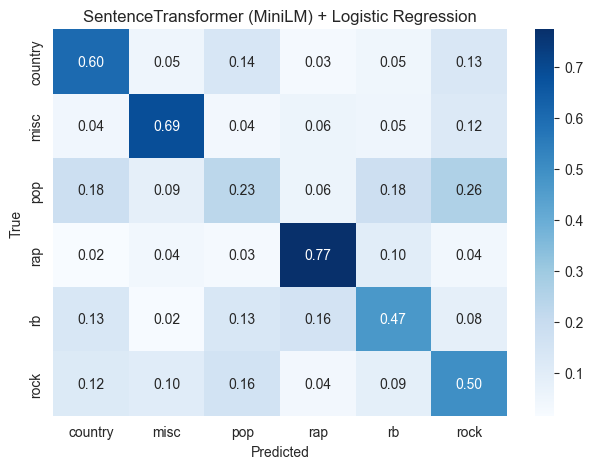

In [197]:
cm = confusion_matrix(y_test, y_pred_st_logreg, labels=np.arange(len(label_encoder.classes_)))

cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

plt.figure()
sns.heatmap(
    cm_norm,
    annot=True,
    cmap="Blues",
    fmt=".2f",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
)
plt.title("SentenceTransformer (MiniLM) + Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

### 2.4.3 Train Classification-Model (Random Forest)

In [198]:
X_train_st_rf = np.asarray(X_train_emb_st)
X_test_st_rf  = np.asarray(X_test_emb_st)

In [199]:
clf_st_rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=20,
    min_samples_leaf=3,
    max_features="sqrt",
    class_weight="balanced",
    n_jobs=-1,
    random_state=42,
)

clf_st_rf.fit(X_train_st_rf, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",400
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",20
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",3
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y

In [200]:
y_pred_st_rf = clf_st_rf.predict(X_test_st_rf)

print("=== SentenceTransformer (MiniLM) + Random Forest ===")
print("Accuracy:", accuracy_score(y_test, y_pred_st_rf))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred_st_rf))
print("\nClassification report:\n")
print(classification_report(
    y_test,
    y_pred_st_rf,
    labels=np.arange(len(label_encoder.classes_)),
    target_names=label_encoder.classes_
))

=== SentenceTransformer (MiniLM) + Random Forest ===
Accuracy: 0.6242290748898679
Balanced accuracy: 0.3434870904594655

Classification report:

              precision    recall  f1-score   support

     country       0.00      0.00      0.00       174
        misc       0.88      0.26      0.40       290
         pop       0.55      0.87      0.68      2820
         rap       0.78      0.79      0.78      1945
          rb       0.00      0.00      0.00       306
        rock       0.57      0.15      0.23      1275

    accuracy                           0.62      6810
   macro avg       0.46      0.34      0.35      6810
weighted avg       0.60      0.62      0.57      6810



/Users/selinasteiner/Desktop/TA/TA-Project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1847: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/selinasteiner/Desktop/TA/TA-Project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1847: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/selinasteiner/Desktop/TA/TA-Project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1847: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


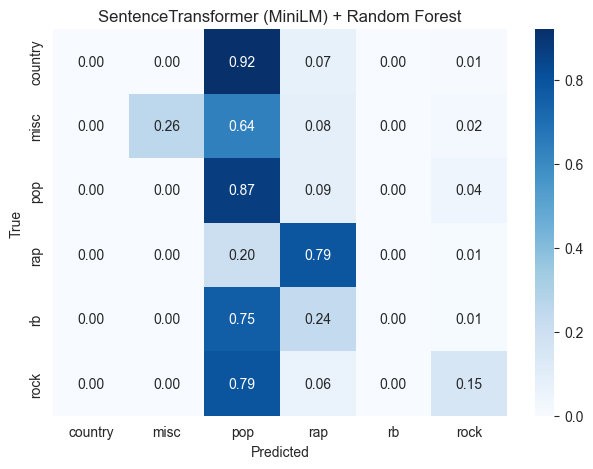

In [201]:
cm = confusion_matrix(
    y_test,
    y_pred_st_rf,
    labels=np.arange(len(label_encoder.classes_))
)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

plt.figure()
sns.heatmap(
    cm_norm,
    annot=True,
    cmap="Blues",
    fmt=".2f",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
)
plt.title("SentenceTransformer (MiniLM) + Random Forest")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

### 2.3.4 SentenceTransformer (MiniLM) – Summary of Classifier Performance

The three classifiers applied to SentenceTransformer embeddings reveal clear performance differences but follow similar patterns as seen with Word2Vec and TF-IDF.

#### LinearSVC
    - Accuracy: ~0.572
    - Balanced Accuracy: ~0.515
LinearSVC delivers the strongest and most stable performance for Transformer embeddings. It handles the dominant classes (rap, pop) very well and achieves the best compromise between accuracy and class balance. Minority genres benefit from the richer Transformer embeddings, but performance remains moderate due to limited sample sizes.

#### Logistic Regression
    - Accuracy: ~0.475
    - Balanced Accuracy: ~0.543
Logistic Regression again provides the most balanced predictions across classes, achieving a high balanced accuracy. Similar to earlier embeddings, its overall accuracy drops because it struggles to correctly classify the large pop class. However, recall for minority genres improves more than with LinearSVC.

#### Random Forest
    - Accuracy: ~0.624
    - Balanced Accuracy: ~0.343
Random Forest reaches the highest accuracy among the Transformer-based models, mainly due to strong recall on pop and rap. However, it performs extremely poorly on minority genres (country, rb), producing a very low balanced accuracy. This indicates a pronounced bias toward majority classes despite the richer Transformer features.

#### Conclusion

**Best overall performer:** LinearSVC (strongest balance between accuracy, stability, and fair class distribution)

**Best for minority classes:** Logistic Regression (highest balanced accuracy)

**Best raw accuracy but least fair:** Random Forest (strong performance on dominant classes but weak generalization to minority genres)

# 3. Model Comparison
## 3.1 Overview

| Embedding            | Classifier          | Accuracy | Balanced Accuracy | Interpretation |
|:---------------------|:--------------------|:---------|:------------------|:---------------|
| **Word2Vec**         | LinearSVC           | ~0.58    | ~0.51             | Strong overall performance; good for dominant genres, reasonable balance across classes |
| **Word2Vec**         | Logistic Regression | ~0.46    | ~0.55             | Most balanced across genres; better recall for minority classes but weaker on major genres like pop |
| **Word2Vec**         | Random Forest       | ~0.65    | ~0.40             | Highest raw accuracy; heavily biased toward majority genres, poor performance on minority classes |
| **TF-IDF**           | LinearSVC           | ~0.59    | ~0.46             | Best overall TF-IDF performer; strong on major genres, limited performance on smaller classes |
| **TF-IDF**           | Logistic Regression | ~0.55    | ~0.53             | More balanced across genres; improved minority recall at the cost of some accuracy on dominant genres |
| **TF-IDF**           | Random Forest       | ~0.58    | ~0.40             | Competitive accuracy; still biased toward majority classes, only moderate balance across genres |
| **Transformer (MiniLM)** | LinearSVC       | ~0.57    | ~0.52             | Strongest Transformer model; good accuracy and the best class balance for this embedding |
| **Transformer (MiniLM)** | Logistic Regression | ~0.48 | ~0.54             | Most balanced Transformer classifier; better minority recall but weaker on major genres |
| **Transformer (MiniLM)** | Random Forest   | ~0.62    | ~0.34             | High accuracy but strong majority-class bias; weakest balance among Transformer models |


### 3.2 Final Conclusion & Model Selection

Across all three embedding strategies—Word2Vec, TF-IDF, and Transformer (MiniLM)—the evaluation reveals a consistent pattern:

- LinearSVC delivers the most reliable overall performance, regardless of embedding.

- Logistic Regression consistently improves class balance and recall for minority genres.

- Random Forest often achieves high accuracy but is systematically biased toward majority classes, resulting in poor balanced accuracy.

**Final Model:** SentenceTransformer (MiniLM) + LinearSVC

This model achieves:

- Solid accuracy (~0.57)

- The best balanced accuracy among the high-performing models (~0.52)

- Good performance on both dominant and minority classes

- Robust behaviour across embeddings and classifiers


The Transformer embeddings capture more semantic and contextual information than Word2Vec or TF-IDF. When combined with LinearSVC—which is extremely stable and effective on high-dimensional embeddings—the model provides the strongest generalization while maintaining reasonable fairness across genres.

# 4. Save final Model

In [203]:
# Create output directory
os.makedirs("models", exist_ok=True)

# Save classifier
joblib.dump(clf_st_svc, "models/clf_st_svc.joblib")

# Save label encoder
joblib.dump(label_encoder, "models/label_encoder.joblib")

print("Saved: clf_st_svc.joblib and label_encoder.joblib")

Saved: clf_st_svc.joblib and label_encoder.joblib
